In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.animation as animation

np.random.seed(1234)

In [3]:
# CUDA support
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA")
else:
    device = torch.device("cpu")
    print("CPU")

# device = torch.device("cpu")

CUDA


In [4]:
class DNN(nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        modules = []
        for i in range(len(layers) - 2):  # Exclude last layer for activation
            modules.append(nn.Linear(layers[i], layers[i+1]))
            modules.append(nn.Tanh())
        modules.append(nn.Linear(layers[-2], layers[-1]))  # Last layer (no activation)
        self.network = nn.Sequential(*modules)

        for layer in self.network:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                if layer.bias is not None:
                    nn.init.zeros_(layer.bias)

    def forward(self, x):
        return self.network(x)

In [5]:
lbfgs_lr = 0.001
adam_lr = 0.001

w_pde = 1.0
w_bc = 1.0
w_ic = 1.0

In [29]:
class PINN():
    def __init__(self, X, layers, f, ic1, ic2):
        
        self.x_d = X["d"][0].requires_grad_()
        self.t_d = X["d"][1].requires_grad_()

        self.x_lbc = X["lbc"][0].requires_grad_()
        self.t_lbc = X["lbc"][1].requires_grad_()
        self.x_rbc = X["rbc"][0].requires_grad_()
        self.t_rbc = X["rbc"][1].requires_grad_()

        self.x_ic = X["ic"][0].requires_grad_()
        self.t_ic = X["ic"][0].requires_grad_()

        self.f = f
        self.ic1 = ic1
        self.ic2 = ic2

        # DNN
        self.dnn = DNN(layers).to(device)

        # Optimizer
        self.optimizer_lbfgs = torch.optim.LBFGS(
            self.dnn.parameters(),
            lr=lbfgs_lr,
            max_iter=50000,
            max_eval=50000,
            history_size=50,
            tolerance_grad=1e-5,
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"
        )

        self.optimizer_adam = torch.optim.Adam(self.dnn.parameters(), lr=adam_lr)
        # self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer_adam, step_size=1000, gamma=0.5)
        self.iter = 0

    def model_value(self, x, t):
        out = self.dnn(torch.cat((x, t), dim=1))
        u = out[:,0].view(-1, 1)
        m = out[:,1].view(-1, 1)
        return u, m
    
    def space_derivative(self, u, m, x):
        u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
        u_2x = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]

        m_x = torch.autograd.grad(m, x, torch.ones_like(m), create_graph=True)[0]
        m_2x = torch.autograd.grad(m_x, x, torch.ones_like(m_x), create_graph=True)[0]      

        return u_x, u_2x, m_x, m_2x
    
    def time_derivative(self, u , t):
        u_t = torch.autograd.grad(u, t, torch.ones_like(u), create_graph=True)[0]
        u_2t = torch.autograd.grad(u_t, t, torch.ones_like(u_t), create_graph=True)[0]
        return u_t, u_2t

    def bc_loss(self, x, t):
        u, m = self.model_value(x, t)
        bc_loss = torch.mean(u**2) + torch.mean(m**2)
        return bc_loss
    
    def ic_loss(self, x, t):
        u, _ = self.model_value(x, t)
        u_t, _ = self.time_derivative(u, t)

        ic_loss = torch.mean((u - self.ic1)**2)
        ic_loss += torch.mean((u_t - self.ic2)**2)
        return ic_loss

    def pde(self, x, t):
        u, m = self.model_value(x, t)
        _, _, _, m_2x = self.space_derivative(u, m, x)
        _, u_2t = self.time_derivative(u, t)
        
        pde_loss = torch.mean((u_2t + m_2x - self.f)**2)

        return pde_loss

    def loss_func(self):
        pde_loss = self.pde(self.x_d, self.t_d)
        bc_loss = self.bc_loss(self.x_lbc, self.t_lbc)
        bc_loss += self.bc_loss(self.x_rbc, self.t_rbc)
        ic_loss = self.ic_loss(self.x_ic, self.t_ic)

        # total_loss = w_pde*pde_loss + w_bc*bc_loss + w_ic*ic_loss

        return pde_loss, bc_loss, ic_loss


    def lbfgs_func(self):
        # loss = self.loss_func()
        pde_loss, bc_loss, ic_loss = self.loss_func()
        loss = w_pde*pde_loss + w_bc*bc_loss + w_ic*ic_loss

        self.optimizer_lbfgs.zero_grad()
        loss.backward()

        self.iter += 1
        if self.iter % 100 == 0:
            print(f"Iter: {self.iter}, Loss: {'{:e}'.format(loss.item())}")
            print(f"PDE: {'{:e}'.format(pde_loss.item())}, BC: {'{:e}'.format(bc_loss.item())}, IC: {'{:e}'.format(ic_loss.item())}")
        return loss
    
    def train(self, epochs=1000):
        self.dnn.train()
        for epoch in range(epochs):
            # loss = self.loss_func()
            pde_loss, bc_loss, ic_loss = self.loss_func()
            loss = w_pde*pde_loss + w_bc*bc_loss + w_ic*ic_loss

            self.optimizer_adam.zero_grad()
            loss.backward()
            self.optimizer_adam.step()
            # self.scheduler.step()

            if epoch % 200 == 0:
                print(f"Epoch {epoch}, Loss: {'{:e}'.format(loss.item())}")
                print(f"PDE: {'{:e}'.format(pde_loss.item())}, BC: {'{:e}'.format(bc_loss.item())}, IC: {'{:e}'.format(ic_loss.item())}")
                # print(f"Current LR: {self.scheduler.get_last_lr()[0]}")
        self.optimizer_lbfgs.step(self.lbfgs_func)

    def predict(self, x, t):
        x = torch.tensor(x).float().to(device)
        t = torch.tensor(t).float().to(device)

        self.dnn.eval()
        u, _ = self.model_value(x, t)
        u = u.detach().cpu().numpy()
        return u

In [7]:
def func(x, t):
    return (1-16*np.pi**2) * np.sin(x) * np.cos(4*np.pi*t)

In [24]:
def generate_points(points):
    def ic_points(n_points):
        x = torch.rand((n_points, 1), device=device) * torch.pi
        t = torch.zeros((n_points, 1), device=device)
        return x, t

    def bc_points(n_points, x_bc):
        x = torch.ones((n_points, 1), device=device) * x_bc
        t = torch.rand((n_points, 1), device=device)
        return x, t

    def domain_points(n_points):
        x = torch.rand((n_points, 1), device=device) * torch.pi
        t = torch.rand((n_points, 1), device=device)
        return x, t
    
    x_d, t_d = domain_points(points[0])
    x_lbc, t_lbc = bc_points(points[1], 0)
    x_rbc, t_rbc = bc_points(points[1], torch.pi)
    x_ic, t_ic = ic_points(points[2])


    generated_points = {"d": [x_d, t_d], "lbc": [x_lbc, t_lbc], "rbc": [x_rbc, t_rbc], "ic": [x_ic, t_ic]}
    return generated_points

In [32]:
points = [10000, 2000, 2000]
collocation = generate_points(points)


x_d = collocation["d"][0]
t_d = collocation["d"][1]

x_ic = collocation["ic"][0]


f = lambda x, t: (1 - 16*torch.pi**2)*torch.sin(x)*torch.cos(4*torch.pi*t)
ic1 = lambda x: torch.sin(x)
ic2 = lambda x: torch.full_like(x, 0)

vec1 = ic1(x_ic)
vec2 = ic2(x_ic)
fun = f(x_d, t_d)

In [33]:
nodes = 64
layers = [2, nodes, nodes, nodes, nodes, 2]

model = PINN(collocation, layers, fun, vec1, vec2)

In [34]:
model.train(5000)

Epoch 0, Loss: 6.140967e+03
PDE: 6.139890e+03, BC: 2.976054e-01, IC: 7.797107e-01
Epoch 200, Loss: 4.456702e+02
PDE: 4.305164e+02, BC: 5.535701e+00, IC: 9.618065e+00
Epoch 400, Loss: 4.099742e+01
PDE: 1.817334e+01, BC: 3.986272e+00, IC: 1.883781e+01
Epoch 600, Loss: 3.120910e+01
PDE: 1.246441e+01, BC: 3.486560e+00, IC: 1.525812e+01
Epoch 800, Loss: 4.549190e+01
PDE: 3.000954e+01, BC: 3.059708e+00, IC: 1.242266e+01
Epoch 1000, Loss: 2.186832e+01
PDE: 9.038948e+00, BC: 2.325172e+00, IC: 1.050420e+01
Epoch 1200, Loss: 1.529159e+01
PDE: 5.109833e+00, BC: 1.274577e+00, IC: 8.907176e+00
Epoch 1400, Loss: 1.086797e+01
PDE: 2.267513e+00, BC: 5.133364e-01, IC: 8.087120e+00
Epoch 1600, Loss: 1.001863e+01
PDE: 1.760998e+00, BC: 3.286753e-01, IC: 7.928957e+00
Epoch 1800, Loss: 9.571397e+00
PDE: 1.466415e+00, BC: 2.800422e-01, IC: 7.824939e+00
Epoch 2000, Loss: 1.118234e+01
PDE: 3.189001e+00, BC: 2.608035e-01, IC: 7.732533e+00
Epoch 2200, Loss: 8.966337e+00
PDE: 1.089910e+00, BC: 2.514685e-01, IC: 

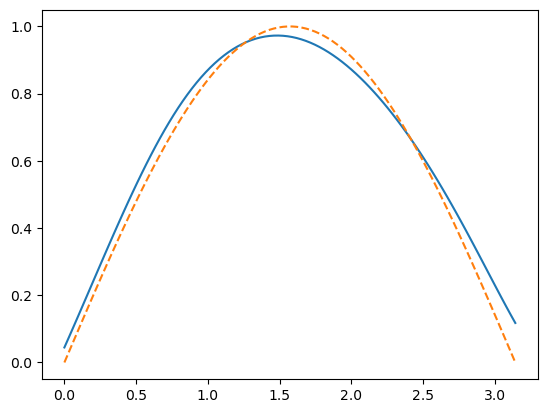

In [35]:

x = np.linspace(0, torch.pi, 100).reshape(-1, 1)
t = np.zeros(100).reshape(-1, 1)

y = np.sin(x)

u = model.predict(x, t)
plt.plot(x, u, label="PINN Solution")
plt.plot(x, y, label="Exact Solution", linestyle="dashed")

In [36]:
# Define the resolution of the grid
x_min, x_max = 0, np.pi  # X range
t_min, t_max = 0, 1  # Time range
grid_size = 100  # Number of points in each dimension

# Create a meshgrid
x_vals = np.linspace(x_min, x_max, grid_size)
t_vals = np.linspace(t_min, t_max, grid_size)
X, T = np.meshgrid(x_vals, t_vals)  # Create a 2D meshgrid

# Flatten the meshgrid and convert to PyTorch tensor
X_flat = X.flatten().reshape(-1, 1)
T_flat = T.flatten().reshape(-1, 1)

u_exact = np.sin(X_flat) * np.cos(4 * torch.pi * T_flat)
u_pred = model.predict(X_flat, T_flat)

abs_error = np.abs(u_pred - u_exact)
l2_error = np.linalg.norm(u_pred - u_exact) / np.linalg.norm(u_exact, 2)

u_pred = u_pred.reshape(grid_size, grid_size)
u_exact = u_exact.reshape(grid_size, grid_size)
abs_error = abs_error.reshape(grid_size, grid_size)

print(l2_error)

0.3290133273667878


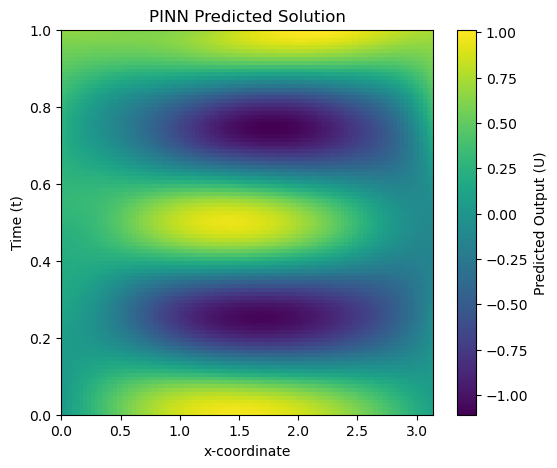

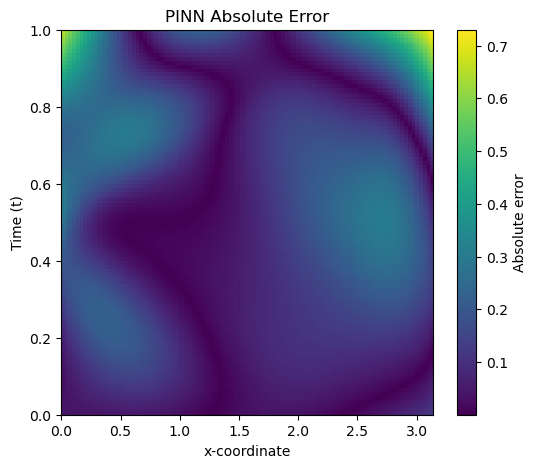

In [37]:

plt.figure(figsize=(6, 5))
plt.imshow(u_pred, extent=[x_min, x_max, t_min, t_max], origin="lower", aspect="auto")
plt.colorbar(label="Predicted Output (U)")
plt.xlabel("x-coordinate")
plt.ylabel("Time (t)")
plt.title("PINN Predicted Solution")


plt.figure(figsize=(6, 5))
plt.imshow(abs_error, extent=[x_min, x_max, t_min, t_max], origin="lower", aspect="auto")
plt.colorbar(label="Absolute error")
plt.xlabel("x-coordinate")
plt.ylabel("Time (t)")
plt.title("PINN Absolute Error")

plt.show()